# README

This notebook is a part of the implementation of ["Adversarial Network Traffic: Towards Evaluating the Robustness of Deep Learning-Based Network Traffic Classification"](https://arxiv.org/abs/2003.01261), including the implementation of flow content classifiers FCC-P, and FCC-HP, and the implementation of AdvPay, and RandPay attacks.

following files and directories are required to replicate the results of the paper:
* FCC/
  * Classifiers/
    * FCC-HP_classifier
    * FCC-P_classifier
  * AdvPay/
    * AdvPay_FCC-HP/(adversarial pad)
    * AdvPay_FCC-P/(adversarial pad)
    * MAKED_PAY/
  * Dataset/
    * Dataset/FCC-HP_Dataset.pickle
    * Dataset/FCC-P_Dataset.pickle


The prerequisites for this notebook are as follows:
1. python 3.6
2. numpy 1.18.2
3. tensorflow-gpu 1.15
4. keras 2.2.5
5. pandas 1.0.3
6. pickle 4.0
7. matplotlib 3.2.1 

All codes have been run on [google colab](https://colab.research.google.com/).


# Configuration
This notebook must run two times in **separate sessions runtime** with different configs from top cell to bottom cell to replicate the results of the paper.

1.   AdvPay and RandPay attacks on FCC-HP
  * FCC = 'FCC-HP' 
  * Train_classifier = 0 
  * Load_advpay = 1 
2.   AdvPay and RandPay attacks on FCC-P
  * FCC = 'FCC-P' 
  * Train_classifier = 0 
  * Load_advpay = 1 

To train a new classifier, first, the input space must be determined by FCC parameter, and then Train_classifier parameter must be set 1 (if you train a new classifier, then new adversarial payload is generated). The trained classifier is saved in FCC/Classifiers directory. The architecture and hyperparameters of the classifier are determined by models.json file.

For example, to train a new classifier FCC-HP and to run AdvPay attack on it, the config is as follows: 
  * FCC = 'FCC-HP' 
  * Train_classifier = 1 
  * Load_advpay = 0

To generate new adversarial payload on existing classifiers, the parameter Load_advpay must be set 0. Generated adversarial payload is saved in FCC/AdvPay/MAKED_PAY directory.

For example, to run AdvPay attack on FCC-P, the config is as follows:
  * FCC = 'FCC-P' 
  * Train_classifier = 0 
  * Load_advpay = 0 




In [0]:
#Config
FCC = 'FCC-HP' # FCC-HP or FCC-P
Train_classifier = 0 # 0 -> Load existing classifiers, and 1 -> Train a new classifier with name Traind_Model in FCC/Classifiers directory 
Load_advpay = 1 # 0 -> Run AdvPay attack and will make new adversarial payload, and 1 -> Load existing adversarial payload that has been used in the paper

%cd 'drive/My Drive/ANT_Paper' # Location of the directory that contains FCC files and directories

# Prerequisites

In [0]:
!pip install tensorflow-gpu==1.15.0
import tensorflow as tf
print(tf.__version__)
# Uninstall tensorflow first
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/content/drive/My Drive/ANT_Paper


1.15.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13610719856051504669, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16378422712112716391
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1201456421982501314
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9331832109892028800
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Utilization

In [0]:
MAX_NUM_PKT_IN_FLOW_SEQ = 10
pkt_size = 1500
NUM_OF_BYTE_IN_FLOW_SEQUENCE = MAX_NUM_PKT_IN_FLOW_SEQ * pkt_size

COUNT_DIRECTION = 1

PAD_PACKET = 1

BATCH_SIZE = 64

if FCC == "FCC-HP":
    INPUT_ITEMS = ['TL','Payload']
if FCC == "FCC-P":
    INPUT_ITEMS = ['Payload'] 

Payload_LENGTH  = 1500
IP_LENGTH = 40
TL_LENGTH = 60

def prepare_data(data, num_of_classes):
    def concat_input_items(p, input_items, p_direction, input_length):
        if True:
            ind = 0
            seq_ind = 0
            seq = np.zeros([input_length])
            ds = 0
            if COUNT_DIRECTION == 1:
                sign = p_direction
            else:
                sign = 1
            if 'IP' in input_items:
                ip = p[ind] * sign
                ind += 1
                seq[seq_ind:seq_ind + len(ip)] = ip
                seq_ind += len(ip)
            if 'TL' in input_items:
                tl = p[ind] * sign
                ind += 1
                seq[seq_ind:seq_ind + len(tl)] = tl
                seq_ind += len(tl)
            if 'Payload' in input_items:
                pd = p[ind] * sign
                ds = len(pd)
                seq[seq_ind:seq_ind + len(pd)] = pd
                seq_ind += len(pd)
        return seq[:seq_ind],ds

    def flow_to_sequence(flow, input_items, flow_direction, input_length):
        remain_free_bytes = NUM_OF_BYTE_IN_FLOW_SEQUENCE
        seq_of_flow = np.zeros((NUM_OF_BYTE_IN_FLOW_SEQUENCE))
        seq_of_ds = np.zeros((MAX_NUM_PKT_IN_FLOW_SEQ))
        for i in range(len(flow)):
            if remain_free_bytes > 0 and i < MAX_NUM_PKT_IN_FLOW_SEQ:
                seq_of_packet_i,ds_of_pkt_i = concat_input_items(np.array(flow[i]), input_items, flow_direction[i],
                                                     input_length)
                if PAD_PACKET == 0:
                    size_of_valid_space_for_this_seq = min(remain_free_bytes, len(seq_of_packet_i))
                    occupide_size_in_seq_of_flow = NUM_OF_BYTE_IN_FLOW_SEQUENCE - remain_free_bytes
                    seq_of_flow[
                    occupide_size_in_seq_of_flow:occupide_size_in_seq_of_flow + size_of_valid_space_for_this_seq] = seq_of_packet_i[
                                                                                                                    :size_of_valid_space_for_this_seq]
                    remain_free_bytes -= size_of_valid_space_for_this_seq
                else:
                    if len(seq_of_packet_i) > pkt_size:
                        seq_of_packet_i = seq_of_packet_i[:pkt_size]
                    else:
                        seq_of_packet_i = np.pad(seq_of_packet_i, (0, pkt_size - len(seq_of_packet_i)), 'constant')

                    seq_of_flow[i * pkt_size:(i + 1) * pkt_size] = seq_of_packet_i
                    seq_of_ds[i] = ds_of_pkt_i
        return seq_of_flow, seq_of_ds

    input_length = 0
    #print(data.input_items)
    if 'IP' in data.input_items:
        #print('IP')
        input_length += 40
    if 'TL' in data.input_items:
        #print('TL')
        input_length += 60
    if 'Payload' in data.input_items:
        #print('Payload')
        input_length += 1500
    train_x = []
    train_x_ds = []

    count_data_of_each_class = np.zeros((len(np.unique(data.train_labels_1))))
    for i in range(len(data.train_data)):
        count_data_of_each_class[data.train_labels_1[i]] += 1
        seq_flow,seq_ds = flow_to_sequence(data.train_data[i], data.input_items, data.train_flow_direction[i], input_length)
        train_x.append(seq_flow)
    # data augmentation

    count_data_of_each_class = np.array(list(map(int, count_data_of_each_class)))
    #print(count_data_of_each_class)
    max_data_in_a_class = max(count_data_of_each_class)
    while min(count_data_of_each_class) != max(count_data_of_each_class):
        for i in range(len(data.train_data)):
            if count_data_of_each_class[data.train_labels_1[i]] < max_data_in_a_class:
                seq_flow, seq_ds = flow_to_sequence(data.train_data[i], data.input_items, data.train_flow_direction[i], input_length)
                train_x.append(seq_flow)
                data.train_labels_1 = np.append(data.train_labels_1, data.train_labels_1[i])
                count_data_of_each_class[data.train_labels_1[i]] += 1
    #print(count_data_of_each_class)
    train_y = np.eye(num_of_classes[0])[data.train_labels_1]
    shuffle_index = np.arange(len(train_x))
    np.random.shuffle(shuffle_index)
    train_x = np.array(train_x)[shuffle_index]
    train_y = train_y[shuffle_index]
    test_x = []
    test_x_port_attack = []
    test_x_ds = []
    for i in range(len(data.test_data)):
        seq_flow,seq_ds = flow_to_sequence(data.test_data[i], data.input_items, data.test_flow_direction[i], input_length)
        test_x.append(seq_flow)
        test_x_ds.append(seq_ds)
        seq_flow_port_attack,seq_ds_port_attack = flow_to_sequence(data.test_port_attack_data[i], data.input_items, data.test_flow_direction[i], input_length)
        test_x_port_attack.append(seq_flow_port_attack)
    test_y = np.eye(num_of_classes[0])[data.test_labels_1]
    test_x = np.array(test_x)
    test_x_port_attack = np.array(test_x_port_attack)
    test_x_ds = np.array(test_x_ds)
    validation_x = []
    validation_x_ds = []
    validation_x_port_attack = []
    for i in range(len(data.validation_data)):
        seq_flow, seq_ds = flow_to_sequence(data.validation_data[i], data.input_items, data.validation_flow_direction[i], input_length)
        validation_x.append(seq_flow)
        validation_x_ds.append(seq_ds)
        seq_flow_port_attack, seq_ds = flow_to_sequence(data.validation_port_attack_data[i], data.input_items, data.validation_flow_direction[i], input_length)
        validation_x_port_attack.append(seq_flow_port_attack)
    validation_y = np.eye(num_of_classes[0])[data.validation_labels_1]
    validation_x = np.array(validation_x)
    validation_x_port_attack = np.array(validation_x_port_attack)
    validation_x_ds = np.array(validation_x_ds)

    return train_x, train_y, validation_x, validation_y, test_x, test_y, validation_x_ds, test_x_ds, test_x_port_attack, validation_x_port_attack

def print_result_statistics(data, pred, overhead_array=None):
    index_name = data.traget_classification_index  # default is activity
    confusion_matrix = np.zeros([len(data.name[index_name]) + 1, len(data.name[index_name]) + 1])
    true_of_each_data_category = np.zeros((len(data.name[0]), len(data.name[1]), len(data.name[2])))
    total_of_each_data_category = np.zeros((len(data.name[0]), len(data.name[1]), len(data.name[2])))
    true_count = 0
    total_count = len(pred)
    for i in range(len(pred)):
        type_label = np.where(data.name[0] == data.test_information[i][-3])[0][0]
        app_label = np.where(data.name[1] == data.test_information[i][-2])[0][0]
        act_label = np.where(data.name[2] == data.test_information[i][-1])[0][0]
        dest_port = int(data.test_information[i][3])
        total_of_each_data_category[type_label, app_label, act_label] += 1
        if np.argmax(pred[i]) == data.test_labels_1[i]:
            confusion_matrix[np.argmax(pred[i]), np.argmax(pred[i])] += 1
            true_of_each_data_category[type_label, app_label, act_label] += 1
            true_count += 1
        else:
            confusion_matrix[data.test_labels_1[i], np.argmax(pred[i])] += 1
    acc_of_each_data_category = np.round(true_of_each_data_category / total_of_each_data_category, 4) * 100
    f_score_array = np.zeros([len(data.name[index_name])])

    for i in range(len(data.name[index_name])):
        confusion_matrix[-1, i] = np.round(confusion_matrix[i, i] / np.sum(confusion_matrix[:, i]), 4) * 100
        confusion_matrix[i, -1] = np.round(confusion_matrix[i, i] / np.sum(confusion_matrix[i, :]), 4) * 100
        f_score_array[i] =  np.round((2 * (confusion_matrix[-1, i] * confusion_matrix[i, -1])) / (confusion_matrix[-1, i] + confusion_matrix[i, -1]),2)
    confusion_matrix[-1, -1] = np.round(true_count / total_count, 4) * 100

    print("\n\nConfusion matrix: row, true label and column, predicted label\n")
    data_frame = pd.DataFrame(confusion_matrix, columns=np.append(data.name[index_name], ['Recall']),
                              index=np.append(data.name[index_name], ['Precision']))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(data_frame)
    print("\n\n Overall Accuracy = ", true_count / total_count)

    return np.array([f_score_array,confusion_matrix[-1, :6],confusion_matrix[:6, -1],confusion_matrix[-1, -1]])



# FCC Dataset


In [0]:
import pickle
import numpy as np
import pandas as pd
class DATASET:
    def __init__(self):
        self.name = 0
        self.train_data = 0;self.train_flow_direction = 0;self.train_information = 0;self.train_labels_1 = 0;
        self.validation_data = 0;self.validation_labels_1 = 0;self.validation_port_attack_data = 0;self.validation_information = 0;self.validation_flow_direction = 0;
        self.test_data = 0;self.test_port_attack_data = 0;self.test_information = 0;self.test_labels_1 = 0;self.test_flow_direction = 0;
        self.traget_classification_index = 0;self.validation_ds = 0;self.test_ds = 0;self.input_items = 0;

print("Dataset Loading ...",end=' ')
if FCC == "FCC-HP":
    file = open("FCC/Dataset/FCC-HP_dataset.pickle", 'rb')
if FCC == "FCC-P":
    file = open("FCC/Dataset/FCC-P_dataset.pickle", 'rb')
data = pickle.load(file)
file.close()
NUM_OF_CLASSES = [len(data.name[data.traget_classification_index])]
train_data_stat = np.array([sum(data.train_labels_1 == i) for i in range(6)])
valid_data_stat = np.array([sum(np.array(data.validation_labels_1) == i) for i in range(6)])
test_data_stat = np.array([sum(np.array(data.test_labels_1) == i) for i in range(6)])
print("Dataset is loaded!!!")
print("\nNumber of data in Train:", data.train_data.shape[0], "Test", np.array(data.test_data).shape[0], "Validation",np.array(data.validation_data).shape[0])
print("\nNumber of data in orginal dataset for all classes:")
data_frame = pd.DataFrame([train_data_stat,valid_data_stat,test_data_stat,train_data_stat+valid_data_stat+test_data_stat], columns=data.name[2],
                              index=['Train Data','Validation data','Test data','Total'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_frame)
train_x, train_y, validation_x, validation_y, test_x, test_y, validation_ds, test_ds,test_x_port_attack,validation_x_port_attack  = prepare_data(data=data,
                                                                            num_of_classes=NUM_OF_CLASSES)
train_data_stat = np.array([sum(np.argmax(train_y,axis=1) == i) for i in range(6)])
valid_data_stat = np.array([sum(np.argmax(validation_y,axis=1) == i) for i in range(6)])
test_data_stat = np.array([sum(np.argmax(test_y,axis=1) == i) for i in range(6)])
print("\nNumber of data in oversampled dataset for all classes:")
data_frame = pd.DataFrame([train_data_stat,valid_data_stat,test_data_stat,train_data_stat+valid_data_stat+test_data_stat], columns=data.name[2],
                              index=['Train Data','Validation data','Test data','Total'])
del data.train_data
del data.validation_data
del data.test_data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_frame)

Dataset Loading ... Dataset is loaded!!!

Number of data in Train: 3275 Test 1093 Validation 1092

Number of data in orginal dataset for all classes:
                 chat  email  filetransfer  streaming  torrent  voip
Train Data        321    235           852        668      240   959
Validation data   108     78           284        223       80   319
Test data         107     79           284        223       80   320
Total             536    392          1420       1114      400  1598

Number of data in oversampled dataset for all classes:
                 chat  email  filetransfer  streaming  torrent  voip
Train Data        959    959           959        959      959   959
Validation data   108     78           284        223       80   319
Test data         107     79           284        223       80   320
Total            1174   1116          1527       1405     1119  1598


# FCC Classifier Training
If Train_classifier parameter is 0, then this cell only shows the performance of the existing classifier on test set.

In [0]:
import json
from keras.models import Sequential, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform, glorot_normal, he_normal
from keras.optimizers import Adamax, RMSprop, SGD, Adadelta
from keras.callbacks import ModelCheckpoint

EPOCH = 1000

def train(train_x, train_y, validation_x, validation_y, model_info, file_name, num_classes, batch_size=None,
          load_path=None):
    """
    Standard neural network training procedure.
    """
    
    if load_path != None:
        model = load_model(load_path)  # + '_' + CLASSIFICATION_TARGET)
        print(model.summary())
        print("Model Loaded!!!")
        return model
    if model_info['Num of blocks'] != 0:
        input_shape = (NUM_OF_BYTE_IN_FLOW_SEQUENCE, 1)
        train_x = np.expand_dims(np.array(train_x), axis=2)
        validation_x = np.expand_dims(np.array(validation_x), axis=2)
    else:
        input_shape = (NUM_OF_BYTE_IN_FLOW_SEQUENCE,)
        train_x = np.array(train_x)
        validation_x = np.array(validation_x)
    
    model = Sequential()

    for i in range(model_info['Num of blocks']):
        for j in range(model_info['Num of conv layer in block']):
            conv_index = i * model_info['Num of conv layer in block'] + j
            if conv_index == 0:
                model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                 kernel_size=model_info['Conv_Kernel_size'][conv_index], input_shape=input_shape,
                                 strides=model_info['Conv_stride_size'][conv_index], padding=model_info['Conv padding'],
                                 name='block' + str(i + 1) + '_conv' + str(j + 1)))
            else:
                model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                 kernel_size=model_info['Conv_Kernel_size'][conv_index],
                                 strides=model_info['Conv_stride_size'][conv_index], padding=model_info['Conv padding'],
                                 name='block' + str(i + 1) + '_conv' + str(j + 1)))
            if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                'Conv_Batch normalization place'] == 'before activation':
                model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
            if model_info['Conv_Activations'] == 'relu':
                model.add(Activation('relu', name='block' + str(i + 1) + '_act' + str(j + 1)))
            if model_info['Conv_Activations'] == 'elu':
                model.add(ELU(alpha=1.0, name='block' + str(i + 1) + '_act' + str(j + 1)))
            if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                'Conv_Batch normalization place'] == 'after activation':
                model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
            if model_info['Conv_Dropout'] == 'yes':
                if model_info['Conv_Dropout rate'][conv_index] >= 1.:
                    print("Bad Dropout rate", model_info['Conv_Dropout rate'])
                    quit()
                model.add(Dropout(model_info['Conv_Dropout rate'][conv_index],
                                  name='block' + str(i + 1) + '_dropout' + str(j + 1)))
        if model_info['Conv_MaxPooling1D'] == 'yes':
            model.add(MaxPooling1D(pool_size=model_info['Pool_size'][i], strides=model_info['Pool_stride_size'][i],
                                   padding=model_info['Conv_MaxPooling1D padding'],
                                   name='block' + str(i + 1) + '_pool'))
    if model_info['Num of blocks'] != 0:
        model.add(Flatten(name='flatten'))
    for i in range(model_info['Num of fully connected layers']):
        if model_info['Num of blocks'] == 0:
            model.add(Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=he_normal(),
                            input_shape=input_shape, name='fc' + str(i + 1)))
        else:
            model.add(Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=he_normal(),
                            name='fc' + str(i + 1)))
        if model_info['FC_Batch normalization'] == 'yes' and model_info[
            'FC_Batch normalization place'] == 'before activation':
            model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
        if model_info['FC_Activations'] == 'relu':
            model.add(Activation('relu', name='fc' + str(i + 1) + '_act'))
        if model_info['FC_Activations'] == 'elu':
            model.add(ELU(alpha=1.0, name='fc' + str(i + 1) + '_act'))
        if model_info['FC_Batch normalization'] == 'yes' and model_info[
            'FC_Batch normalization place'] == 'after activation':
            model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
        if model_info['FC_Dropout'] == 'yes':
            if model_info['FC_Dropout rate'][i] >= 1.:
                print("Bad Dropout rate", model_info['FC_Dropout rate'])
                quit()
            model.add(Dropout(model_info['FC_Dropout rate'][i], name='fc' + str(i + 1) + '_dropout'))
    model.add(Dense(num_classes[0], kernel_initializer=he_normal(), name='fc' + str(i + 2)))
    model.add(Activation('softmax', name="softmax"))
    print("lr", model_info["Learning rate"])
    if model_info['Optimization'] == 'Adamax':
        OPTIMIZER = Adamax(lr=model_info["Learning rate"])
    if model_info['Optimization'] == 'SGD':
        OPTIMIZER = SGD(lr=model_info["Learning rate"])
    if model_info['Optimization'] == 'RMSprop':
        OPTIMIZER = RMSprop(lr=model_info["Learning rate"])
    if model_info['Optimization'] == 'Adadelta':
        OPTIMIZER = Adadelta(lr=model_info["Learning rate"])

    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
                  metrics=["accuracy"])
    print("Model compiled")
    print(model.summary())

    if True: 
        best_model_save = ModelCheckpoint('FCC/Classifiers/Trained_Model.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True,
                                          save_weights_only=True, mode='max', period=1)
        history = model.fit(train_x, train_y,
                            batch_size=batch_size, epochs=EPOCH, verbose=2, callbacks=[best_model_save], shuffle=True,
                            validation_data=(validation_x, validation_y))
        print("Load Best Model...")
        model.load_weights('FCC/Classifiers/Trained_Model.hdf5')
        model.save('FCC/Classifiers/Trained_Model.hdf5')
        return model

with open('FCC/Classifiers/models.json') as json_file:
    models = json.load(json_file)
for model_index in range(len(models)):
    print("model", model_index)

    if Train_classifier == 1:
        model_path = None
    else:
      if FCC == "FCC-HP":
          model_path = "FCC/Classifiers/FCC-HP_classifier.hdf5"
      if FCC == "FCC-P":
          model_path = "FCC/Classifiers/FCC-P_classifier.hdf5"

    flow_classification_model = train(train_x/255, train_y, validation_x/255,validation_y, 
                                                  model_info=models[model_index],file_name="FCC/Classifiers/Trained_Model",
                                                  num_classes=NUM_OF_CLASSES,batch_size=BATCH_SIZE, load_path= model_path)
    expanded_test_x = np.expand_dims(np.array(test_x / 255), axis=2)
    pred = flow_classification_model.predict(expanded_test_x)
    result_stat = print_result_statistics(data, pred)
    del flow_classification_model

Using TensorFlow backend.


model 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv1D)        (None, 15000, 32)         160       
_________________________________________________________________
block1_act1 (ELU)            (None, 15000, 32)         0         
_________________________________________________________________
block1_BN1 (BatchNormalizati (None, 15000, 32)         128       
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 7500, 32)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 7500, 64)          8256      
_________________________________________________________________
block2_act1 (ELU)            (None, 7500, 64)          0         
_____________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


# AdvPay Attack

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input
import time
from keras.models import load_model
import numpy as np
class Crafted_Dummy_Packet():
    def __init__(self,json_path=None,keras_model_path=None,class_number = None, batch_size = None,flow_seq_size = None):
        self.keras_model_path = keras_model_path
        self.model_inf_json = json_path
        self.class_number = class_number
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.batch_size = batch_size
        self.flow_seq_size = flow_seq_size
        self.load_advpay_operations()


    def make_advpay(self,data_x=None,data_y=None, lr = 0.001, train_steps = 1000,advpay_size=None,start_index_vector=None):
        start_time = time.time()
        self.reset_advpay()

        for i in range(train_steps):
            if i % 100 == 0:
                print('Step:',i)
            data_index = np.random.randint(len(data_x), size=self.batch_size)
            batch_x = data_x[data_index]
            batch_y = data_y[data_index]
            start_index = start_index_vector[data_index]
            self.train_step(batch_x,batch_y,start_index=start_index, lr=lr,advpay_size=advpay_size)
        elapsed_time = time.time() - start_time
        print("Finished training Advpay, took {:.0f}s".format(elapsed_time))
        return self.advpay()

    def train_step(self,train_data,src_label,start_index, lr=0.001,advpay_size=None):
        feed_dict = {self.flow_seq_input: np.asarray(train_data).reshape([self.batch_size,self.flow_seq_size,1]),
                     self._src_ys: src_label,
                     self._learning_rate: lr,
                     self.start_loc_of_advpay_placeholder: start_index,
                     self.learning_phase: False,
                     self.dropout: 1.0,
                     self.advpay_length: advpay_size}
        assert np.sum(np.array([i[j[0]:j[0]+int(advpay_size)]for i,j in zip(train_data,start_index)])) == 0, "Bad packet to add advpay"
        _,fmask,advmask,grad,loss,new_advpay,prob,pi = self.sess.run([self._train_op,self.flow_seq_mask,self.advpay_mask,self._grad_opt,self._loss,self._clipped_advpay,self._probabilities,self._advpayed_input], feed_dict)
        assert np.sum( new_advpay < 0 ) == 0, "Bad Advpay"


    def advpay(self, new_advpay=None):
        if new_advpay is None:
            return self.sess.run(self._clipped_advpay, {self.learning_phase: False})

        self.sess.run(self._assign_advpay, {self._advpay_placeholder: new_advpay, self.learning_phase: False})
        return self


    def reset_advpay(self):
        self.advpay(np.zeros((self.flow_seq_size,1)))

    def load_advpay_operations(self):
        start = time.time()
        K.set_session(self.sess)
        with self.sess.graph.as_default():
            keras_model = flow_classification_keras_model(self.model_inf_json,self.keras_model_path,input_length=self.flow_seq_size,num_classes=self.class_number)


            self.learning_phase = K.learning_phase() # if 1 -> train. if 0 -> test. (must be set in test or train time )
            Trace_shape = (self.flow_seq_size,1)
            self.flow_seq_input = Input(shape=Trace_shape) # input (set in test or train time )
            Trace_input = self.flow_seq_input
            self.Trace_advpay = tf.Variable(initial_value=tf.zeros((self.flow_seq_size,1)), dtype=tf.float32,name="advpay")
            self._advpay_placeholder = tf.placeholder(dtype=tf.float32, shape=(self.flow_seq_size,1),name='advpay_placeholder')
            self.start_loc_of_advpay_placeholder = tf.placeholder(dtype=tf.int32, shape=[self.batch_size,1],name='start_location_placeholder')
            self.advpay_length = tf.placeholder(dtype=tf.int32, shape=(),name='advpay_length')
            self._assign_advpay = tf.assign(self.Trace_advpay, self._advpay_placeholder) # assign _advpay_placeholder to advpay
            self.modified_advpay = self.Trace_advpay


            def clip_to_valid_advpay(x):
                return tf.clip_by_value(x, clip_value_min=0., clip_value_max=1.) # client to server packet is positive


            self._clipped_advpay = clip_to_valid_advpay(
                self.modified_advpay)  # after making advpay, use this variable to get path

            self.dropout = tf.placeholder_with_default(1.0, [])
            advpay_with_dropout = tf.nn.dropout(self._clipped_advpay, keep_prob=self.dropout)
            advpayed_input = self.add_advpay_to_flow_seq(Trace_input, advpay_with_dropout,self.start_loc_of_advpay_placeholder,self.advpay_length)

            self._advpayed_input = advpayed_input

            self._src_ys = tf.placeholder(tf.float32, shape=(None, self.class_number[0]), name="target_ys")

            self.logits = keras_model.predict([advpayed_input])

            self._loss_per_example = tf.nn.softmax_cross_entropy_with_logits(
                labels=self._src_ys,
                logits=self.logits
            )
            self._loss = tf.reduce_mean(self._loss_per_example) * -1 # it increases the loss of src class

            # Train our attack by only training on the advpay variable
            self._learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            self._optimizer = tf.train.RMSPropOptimizer(self._learning_rate)
            self._grad_opt = self._optimizer.compute_gradients(self._loss,var_list=[self.Trace_advpay])
            self._train_op = self._optimizer.apply_gradients(self._grad_opt)

            self._probabilities = tf.nn.softmax(logits=self.logits)
            elapsed = time.time() - start
            print("Finished loading , took {:.0f}s".format( elapsed))
            self.sess.run(tf.variables_initializer(self._optimizer.variables()))

    def add_advpay_to_flow_seq(self, data, advpay,start_advpay_index,advpay_length):

        stacked_advpay = tf.stack([advpay] * self.batch_size)
        self.clean_data_seq = data

        flow_seq_mask = []
        def _mask_vecs(start,advpay_size):
            flow_mask = np.zeros([self.flow_seq_size, 1])
            flow_mask[:start[0]] = 1
            flow_mask[start[0]+advpay_size:self.flow_seq_size] = 1
            return flow_mask.astype(np.float32)

        for i in range(self.batch_size):
            flow_seq_mask_vec = tf.py_func(_mask_vecs, [start_advpay_index[i],advpay_length], tf.float32)
            flow_seq_mask_vec.set_shape([self.flow_seq_size, 1])
            flow_seq_mask.append(flow_seq_mask_vec)
        self.flow_seq_mask = tf.stack(flow_seq_mask)

        shifted_stacked_advpay = []
        for i in range(self.batch_size):
            shifted_stacked_advpay_vec = tf.roll(stacked_advpay[i], start_advpay_index[i][0], axis=0)
            shifted_stacked_advpay.append(shifted_stacked_advpay_vec)
        self.shifted_stacked_advpay_array = tf.stack(shifted_stacked_advpay)

        self.advpay_mask = 1 - self.flow_seq_mask
        self.advpayed_flow_seq = self.clean_data_seq * self.flow_seq_mask + self.shifted_stacked_advpay_array * self.advpay_mask
        return self.advpayed_flow_seq

    def inference_batch(self, test_x, test_y,start_index_vec=0, advpay_size=None):
        test_x = np.expand_dims(np.array(test_x), axis=2)
        Evade = 0
        total = 0
        pred = []
        for i in range(int(np.ceil(len(test_x) / self.batch_size))):
            batch_x = test_x[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            batch_true = test_y[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            start_index = start_index_vec[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            orginal_len_batch = len(batch_x)
            while len(batch_x) != self.batch_size:
                dummy_data_num = self.batch_size - len(batch_x)
                batch_x = np.append(batch_x, batch_x[:dummy_data_num], axis=0)
                batch_true = np.append(batch_true, batch_true[:dummy_data_num], axis=0)
                start_index = np.append(start_index, start_index[:dummy_data_num], axis=0)

            feed_dict = {self.flow_seq_input: batch_x, self._src_ys: batch_true,
                         self.start_loc_of_advpay_placeholder: start_index,
                         self.learning_phase: False,
                         self.advpay_length: advpay_size}
            assert np.sum(np.array([i[j[0]:j[0] + int(advpay_size)] for i, j in
                                    zip(batch_x, start_index)])) == 0, "Bad packet to add advpay"

            ps, advpayed_input = self.sess.run([self._probabilities, self._advpayed_input], feed_dict)
            ps = np.array(ps)[:orginal_len_batch]
            if i == 0:
                pred = ps
            else:
                pred = np.append(pred, ps, axis=0)

            for j in range(len(ps)):
                total += 1
                if np.argmax(ps[j]) != np.argmax(batch_true[j]):
                    Evade += 1
        if total == 0:
            total += 1
        return np.round((Evade / total) * 100, 2),total, pred


import json
from keras.models import Sequential, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform, glorot_normal, he_normal

class flow_classification_keras_model:
    def __init__(self,model_inf_json_path,load_path=None,input_length=None,num_classes=None):
        with open(model_inf_json_path) as json_file:
            models = json.load(json_file)
        model_info = models[0]
        if model_info['Num of blocks'] != 0:
            input_shape = (input_length, 1)
        else:
            input_shape = (input_length,)
        print(input_shape)
        model = Sequential()
        
        for i in range(model_info['Num of blocks']):
            for j in range(model_info['Num of conv layer in block']):
                conv_index = i * model_info['Num of conv layer in block'] + j
                if conv_index == 0:
                    model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                     kernel_size=model_info['Conv_Kernel_size'][conv_index],
                                     input_shape=input_shape,
                                     strides=model_info['Conv_stride_size'][conv_index],
                                     padding=model_info['Conv padding'],
                                     name='block' + str(i + 1) + '_conv' + str(j + 1)))
                else:
                    model.add(Conv1D(filters=model_info['Conv_Filter_num'][conv_index],
                                     kernel_size=model_info['Conv_Kernel_size'][conv_index],
                                     strides=model_info['Conv_stride_size'][conv_index],
                                     padding=model_info['Conv padding'],
                                     name='block' + str(i + 1) + '_conv' + str(j + 1)))
                if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                    'Conv_Batch normalization place'] == 'before activation':
                    model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
                if model_info['Conv_Activations'] == 'relu':
                    model.add(Activation('relu', name='block' + str(i + 1) + '_act' + str(j + 1)))
                if model_info['Conv_Activations'] == 'elu':
                    model.add(ELU(alpha=1.0, name='block' + str(i + 1) + '_act' + str(j + 1)))
                if model_info['Conv_Batch normalization'] == 'yes' and model_info[
                    'Conv_Batch normalization place'] == 'after activation':
                    model.add(BatchNormalization(axis=-1, name='block' + str(i + 1) + '_BN' + str(j + 1)))
                if model_info['Conv_Dropout'] == 'yes':
                    if model_info['Conv_Dropout rate'][conv_index] >= 1.:
                        print("Bad Dropout rate", model_info['Conv_Dropout rate'])
                        quit()
                    model.add(Dropout(model_info['Conv_Dropout rate'][conv_index],
                                      name='block' + str(i + 1) + '_dropout' + str(j + 1)))
            if model_info['Conv_MaxPooling1D'] == 'yes':
                model.add(
                    MaxPooling1D(pool_size=model_info['Pool_size'][i], strides=model_info['Pool_stride_size'][i],
                                 padding=model_info['Conv_MaxPooling1D padding'],
                                 name='block' + str(i + 1) + '_pool'))
        if model_info['Num of blocks'] != 0:
            model.add(Flatten(name='flatten'))
        for i in range(model_info['Num of fully connected layers']):
            if model_info['Num of blocks'] == 0:
                model.add(
                    Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=he_normal(),
                          input_shape=input_shape, name='fc' + str(i + 1)))
            else:
                model.add(
                    Dense(model_info['FC_Num of neurons in hidden layers'][i], kernel_initializer=he_normal(),
                          name='fc' + str(i + 1)))
            if model_info['FC_Batch normalization'] == 'yes' and model_info[
                'FC_Batch normalization place'] == 'before activation':
                model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
            if model_info['FC_Activations'] == 'relu':
                model.add(Activation('relu', name='fc' + str(i + 1) + '_act'))
            if model_info['FC_Activations'] == 'elu':
                model.add(ELU(alpha=1.0, name='fc' + str(i + 1) + '_act'))
            if model_info['FC_Batch normalization'] == 'yes' and model_info[
                'FC_Batch normalization place'] == 'after activation':
                model.add(BatchNormalization(name='fc' + str(i + 1) + '_BN'))
            if model_info['FC_Dropout'] == 'yes':
                if model_info['FC_Dropout rate'][i] >= 1.:
                    print("Bad Dropout rate", model_info['FC_Dropout rate'])
                    quit()
                model.add(Dropout(model_info['FC_Dropout rate'][i], name='fc' + str(i + 1) + '_dropout'))
        model.add(Dense(num_classes[0], kernel_initializer=he_normal(), name='fc' + str(i + 2)))

        model.load_weights(load_path)

        self.model = model


    def predict(self, data):
        return self.model(data)


def tune_sequence_number(data,information,advpay_pkt_index_vector=None,advpay_size=None,refrence_pkt_size_vector=None):
    valid_data = []
    for (seq, inf,advpay_pkt_index,ref_pkt_size) in zip(data, information, advpay_pkt_index_vector,refrence_pkt_size_vector):
        if inf[4] == '6':
            for i in range(MAX_NUM_PKT_IN_FLOW_SEQ):
                if i < advpay_pkt_index:
                    continue
                pkt_seq = seq[i*pkt_size:(i+1)*pkt_size]
                hex_seq_no = pkt_seq[4:8]
                if hex_seq_no[0] + hex_seq_no[1] + hex_seq_no[2] + hex_seq_no[3] == 0:
                    continue

                #print(hex_seq_no)
                sign = np.sign(hex_seq_no[0] + hex_seq_no[1] + hex_seq_no[2] + hex_seq_no[3])
                assert len(''.join('{:02X}'.format(np.abs(int(i))) for i in hex_seq_no)) == 8,"very bad"

                seq_no = int(''.join('{:02X}'.format(np.abs(int(i))) for i in hex_seq_no),16)
                #print(seq_no)
                if i == advpay_pkt_index:
                    new_dec_seq_no = np.mod(seq_no + ref_pkt_size,pow(2,32)-1)
                    assert np.sum(pkt_seq[TL_LENGTH:]) == 0, "bad change in header of real packet"
                else:
                    new_dec_seq_no = np.mod(seq_no + advpay_size, pow(2, 32) - 1)
                new_hex = hex(int(new_dec_seq_no)).lstrip("0x")
                if len(new_hex) < 8:
                    new_hex = '0'*(8 - len(new_hex)) + new_hex
                #print(new_hex)
                new_hex_seq_no = [int(j,16) * sign for j in [new_hex[i*2:(i+1)*2] for i in range(4)]]
                #print(new_hex_seq_no)
                new_seq_no = int(''.join('{:02X}'.format(np.abs(int(i))) for i in new_hex_seq_no),16) * sign
                #print(''.join('{:02X}'.format(np.abs(int(i))) for i in new_hex_seq_no))
                #print("new_seq_no",new_seq_no)
                pkt_seq[4:8] = new_hex_seq_no
        valid_data.append(seq)
    return np.array(valid_data)

def make_dummy_pkt_header(data,information,advpay_pkt_index_vector=None,refrence_pkt_header_index=None,advpay_size=None):
    valid_data = []
    for (seq, inf, advpay_pkt_index,ref_hdr_index) in zip(data, information, advpay_pkt_index_vector,refrence_pkt_header_index):
        advpay_pkt_index = advpay_pkt_index[0]
        ref_hdr_index = ref_hdr_index[0]
        assert advpay_pkt_index != ref_hdr_index,"advpay_pkt_index == ref_hdr_index"
        first_part = seq[0:advpay_pkt_index*pkt_size]
        second_part = seq[advpay_pkt_index*pkt_size:]
        seq = np.zeros(seq.shape)
        seq[:advpay_pkt_index*pkt_size] = first_part
        seq[(advpay_pkt_index+1)*pkt_size:] = second_part[:NUM_OF_BYTE_IN_FLOW_SEQUENCE-(advpay_pkt_index+1)*pkt_size]
        seq[advpay_pkt_index*pkt_size:(advpay_pkt_index*pkt_size)+TL_LENGTH] = seq[ref_hdr_index*pkt_size:(ref_hdr_index*pkt_size)+TL_LENGTH]
        if inf[4] == '6':
            seq[(advpay_pkt_index * pkt_size) + 8 :(advpay_pkt_index * pkt_size) + 14] = 0  # All flags set zero
            seq[(advpay_pkt_index * pkt_size) + 18:(advpay_pkt_index * pkt_size) + TL_LENGTH] = 0  # All flags set zero
        elif inf[4] == '17':
            hex_advpay_size = np.array(['{:04X}'.format(np.abs(int(advpay_size)))[:2], '{:04X}'.format(np.abs(int(advpay_size)))[2:]])
            seq[(advpay_pkt_index * pkt_size) + 4:(advpay_pkt_index * pkt_size) + 6] = np.array(
                [int(hex_advpay_size[0], 16), int(hex_advpay_size[1], 16)])
            seq[(advpay_pkt_index * pkt_size) + 8:(advpay_pkt_index * pkt_size) + TL_LENGTH] = 0
        valid_data.append(seq)
    return np.array(valid_data)

def make_room_for_advpay(data,advpay_pkt_index_vector=None):
    valid_data = []
    for (seq,advpay_pkt_index) in zip(data,advpay_pkt_index_vector):
        advpay_pkt_index = advpay_pkt_index[0]
        first_part = seq[:advpay_pkt_index*pkt_size]
        second_part = seq[advpay_pkt_index*pkt_size:]
        seq = np.zeros(seq.shape)
        seq[:advpay_pkt_index*pkt_size] = first_part
        seq[(advpay_pkt_index+1)*pkt_size:] = second_part[:NUM_OF_BYTE_IN_FLOW_SEQUENCE-(advpay_pkt_index+1)*pkt_size]
        valid_data.append(seq)
    return np.array(valid_data)

def prepare_advpay_attack_data(raw_data=None,advpay_pkt_index_vector=None, information=None,datasize=None,advpay_len=None):
    refrence_pkt_header_index = advpay_pkt_index_vector - 1
    assert np.sum(advpay_pkt_index_vector[advpay_pkt_index_vector == 11]) == 0, "Bad advpay index"
    refrence_pkt_size_vector = np.array(
        [datasize[i][int(refrence_pkt_header_index[i])] for i in range(len(raw_data))])

    manipulated_data = make_dummy_pkt_header(data=raw_data, information=information,
                                                     advpay_pkt_index_vector=advpay_pkt_index_vector,
                                                     refrence_pkt_header_index=refrence_pkt_header_index,
                                                     advpay_size=advpay_len)
    manipulated_data= tune_sequence_number(data=manipulated_data,
                                                    information=information,
                                                    advpay_pkt_index_vector=advpay_pkt_index_vector,
                                                    advpay_size=advpay_len,
                                                    refrence_pkt_size_vector=refrence_pkt_size_vector)
    return manipulated_data
    
def health_check(attack_data=None,clean_data=None,start_index_vec=None, information=None):
    assert np.sum([np.sum(k) != 0 for k in np.array([i[:j[0] - (TL_LENGTH * ('TL' in INPUT_ITEMS))] for i, j in
                                                     zip((attack_data - clean_data),
                                                         start_index_vec)])]) == 0, "Packets before advpay are wrong!!! (packet before advpas must have no change)"
    if 'TL' in INPUT_ITEMS:
        for i,j,k,l in zip(attack_data, clean_data, start_index_vec,information):
            if l[4] == '6':
                 assert (np.unique(np.where(
                    i[k[0] - TL_LENGTH + pkt_size:] - j[k[0] - TL_LENGTH:NUM_OF_BYTE_IN_FLOW_SEQUENCE - pkt_size] != 0)[
                              0] % pkt_size) == np.intersect1d(np.where(
                    i[k[0] - TL_LENGTH + pkt_size:] - j[k[0] - TL_LENGTH:NUM_OF_BYTE_IN_FLOW_SEQUENCE - pkt_size] != 0)[
                                                                   0] % pkt_size, [4, 5, 6, 7]))[0], "Tcp packet only change in seq number (4,5,6,7 index in TCP header)"
            elif l[4] == '17':
                assert np.sum(i[k[0] - TL_LENGTH + pkt_size:] - j[k[0] - TL_LENGTH:NUM_OF_BYTE_IN_FLOW_SEQUENCE - pkt_size]) == 0, "UDP packet after advpay must have no change"
    else:
        assert np.sum([np.sum(z) for z in
                       [i[k[0] + pkt_size:] != j[k[0]:NUM_OF_BYTE_IN_FLOW_SEQUENCE - pkt_size] for i, j, k in
                        zip(attack_data, clean_data,
                            start_index_vec)]]) == 0, "Packets after advpay are wrong!!!"
    if 'TL' in INPUT_ITEMS:
        assert np.sum([np.in1d( ii,[0,1,2,3]).any()for ii in [np.where( i[k[0]-TL_LENGTH:k[0]] - j[k[0]-TL_LENGTH - pkt_size:k[0]-pkt_size ] != 0)[0] for i,j,k in zip(attack_data,clean_data,start_index_vector)]]) == 0,"Advpey port differernt from last packet before advpay"
        #assert np.sum([jj == 0 for jj in [ np.sum(ii) for ii in [i[k[0]-TL_LENGTH:k[0]][4:(l[4] == '6') * 8 + (l[4] == '17') * 6] != j[k[0]-TL_LENGTH - pkt_size:k[0]-pkt_size][4:(l[4] == '6') * 8 + (l[4] == '17') * 6] for i,j,k,l in zip(attack_data,clean_data,start_index_vector,information)]]]) == 0, "Advpay sequnce number in TCP or length in UDP is not different from last packet before advpay"


# Generate Adversarial Paylaod

In [0]:
import os 

if FCC == "FCC-HP":
    advpay_directory = "FCC/AdvPay/AdvPay_FCC-HP/"
if FCC == "FCC-P":
    advpay_directory = "FCC/AdvPay/AdvPay_FCC-P/"



# Attck List
AttackList = []
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 0.0   , "Steps": 0}) # No Attack

AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 10.0  , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 50.0  , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 100.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 200.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 300.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 500.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 750.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 1000.0, "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 1200.0, "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 1400.0, "Steps": 1000})

AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 10.0  , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 50.0  , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 100.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 200.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 300.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 500.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 750.0 , "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 1000.0, "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 1200.0, "Steps": 1000})
AttackList.append({"PortAttack": 0, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 1400.0, "Steps": 1000})

if FCC == "FCC-HP":
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 0.0   , "Steps": 0}) # Port Attack

    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 10.0  , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 50.0  , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 100.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 200.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 300.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 500.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 750.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 1000.0, "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 1200.0, "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 1, "AdvPayAttack": 0, "AdvPaySize": 1400.0, "Steps": 1000})

    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 10.0  , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 50.0  , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 100.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 200.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 300.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 500.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 750.0 , "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 1000.0, "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 1200.0, "Steps": 1000})
    AttackList.append({"PortAttack": 1, "RandAttack": 0, "AdvPayAttack": 1, "AdvPaySize": 1400.0, "Steps": 1000})




results_statistics_array = []
random_pay = np.random.randint(255, size=NUM_OF_BYTE_IN_FLOW_SEQUENCE) / 255
maked_advpay_list = []

if FCC == "FCC-HP":
   model_path = "FCC/Classifiers/FCC-HP_classifier.hdf5"
if FCC == "FCC-P":
    model_path = "FCC/Classifiers/FCC-P_classifier.hdf5"
if Train_classifier:
    model_path = "FCC/Classifiers/Trained_Model.hdf5" 

AdvPay_ops = Crafted_Dummy_Packet(json_path='FCC/Classifiers/models.json',keras_model_path=model_path,class_number=NUM_OF_CLASSES,batch_size=BATCH_SIZE,flow_seq_size=NUM_OF_BYTE_IN_FLOW_SEQUENCE)
index_name = data.traget_classification_index


count_attack = 1
for attack in AttackList:
    print("*"*40,"NewAttack","*"*40)
    print("Attack(",count_attack,"/",len(AttackList),"):","PortAttack",attack["PortAttack"],"RandAttack",attack["RandAttack"],"AdvPayAttack",attack["AdvPayAttack"],"AdvPaySize",attack["AdvPaySize"],"Steps",attack["Steps"])
    print("*"*40,"NewAttack","*"*40)

    count_attack += 1

    confusion_matrix = np.zeros([NUM_OF_CLASSES[0], NUM_OF_CLASSES[0]])
    total_p_label = None
    advpay_array = []

    if attack["PortAttack"]:
        clean_validation_x = validation_x_port_attack
        clean_test_x = test_x_port_attack
    else:
        clean_validation_x = validation_x
        clean_test_x = test_x
    validation_advpay_pkt_index_vector = np.array(
        [[next((min(i + 1, 11) for i, j in enumerate(seq) if j == 1), None)] for seq in data.validation_flow_direction])
    test_advpay_pkt_index_vector = np.array(
        [[next((min(i + 1, 11) for i, j in enumerate(seq) if j == 1), None)] for seq in data.test_flow_direction])
    if int(attack["AdvPaySize"]) != 0:
        if 'TL' in INPUT_ITEMS:
            attack_validation_x = prepare_advpay_attack_data(raw_data=clean_validation_x,advpay_pkt_index_vector = validation_advpay_pkt_index_vector, information=data.validation_information,
                                       datasize=validation_ds,advpay_len=attack["AdvPaySize"])
            attack_test_x = prepare_advpay_attack_data(raw_data=clean_test_x,advpay_pkt_index_vector = test_advpay_pkt_index_vector, information=data.test_information,
                                       datasize=test_ds,advpay_len=attack["AdvPaySize"])
        else:
            attack_validation_x = make_room_for_advpay(clean_validation_x,advpay_pkt_index_vector=validation_advpay_pkt_index_vector)
            attack_test_x = make_room_for_advpay(clean_test_x,advpay_pkt_index_vector=test_advpay_pkt_index_vector)
    else:
        attack_validation_x = clean_validation_x
        attack_test_x = clean_test_x


    attack_test_x = attack_test_x / 255
    attack_validation_x = attack_validation_x / 255

    for i in range(NUM_OF_CLASSES[0]):
        print("SRC CLS", data.name[index_name][i])
        if attack['AdvPayAttack'] == 1:
            file_name = advpay_directory + 'advpay_TrainedPay_size_' + str(
                attack['AdvPaySize']) + '_Step_' + str(attack['Steps']) + '_PortAttack_' + str(
                attack['PortAttack'])
            if Load_advpay and os.path.exists(file_name + '.npy') and attack['Steps'] != 0:# and (attack['PortAttack'] != 0 or attack['AdvPaySize'] != 750.0 or i != 4):
                print("advpay loaded!")
                advpay = np.load(file_name + '.npy', allow_pickle=True)[i]
                AdvPay_ops.advpay(advpay)
            elif attack['AdvPaySize'] == 0.0:
                advpay = random_pay.reshape([NUM_OF_BYTE_IN_FLOW_SEQUENCE, 1])
                AdvPay_ops.advpay(advpay)
                print("No Attack")
            else:
                start_index_vector = (validation_advpay_pkt_index_vector * pkt_size) + ('TL' in INPUT_ITEMS) * TL_LENGTH
                attack_validation_x_class_i = attack_validation_x[np.argmax(validation_y,axis=1) == i]
                validation_y_class_i = validation_y[np.argmax(validation_y,axis=1) == i]
                start_index_vector = start_index_vector[np.argmax(validation_y,axis=1) == i]
                clean_validation_x_class_i = clean_validation_x[np.argmax(validation_y,axis=1) == i] / 255
                validation_infirmation_class_i = np.array(data.validation_information)[np.argmax(validation_y,axis=1) == i]
                health_check(attack_data=attack_validation_x_class_i, clean_data=clean_validation_x_class_i, start_index_vec=start_index_vector,information=validation_infirmation_class_i)
                advpay = AdvPay_ops.make_advpay(data_x=attack_validation_x_class_i,data_y=validation_y_class_i,lr=0.001,train_steps=attack['Steps'],advpay_size=attack['AdvPaySize'],start_index_vector=start_index_vector)
            advpay_array.append(advpay)

        if attack['RandAttack'] == 1:
            rand_advpay = AdvPay_ops.advpay(random_pay.reshape([NUM_OF_BYTE_IN_FLOW_SEQUENCE, 1]))
            advpay_array.append(AdvPay_ops.advpay())

        start_index_vector = (test_advpay_pkt_index_vector * pkt_size) + ('TL' in INPUT_ITEMS) * TL_LENGTH
        attack_test_x_class_i = attack_test_x[np.argmax(test_y,axis=1) == i]
        test_y_class_i = test_y[np.argmax(test_y,axis=1) == i]
        start_index_vector = start_index_vector[np.argmax(test_y,axis=1) == i]
        clean_test_x_class_i = clean_test_x[np.argmax(test_y,axis=1) == i] / 255
        test_infirmation_class_i = np.array(data.test_information)[np.argmax(test_y, axis=1) == i]
        if attack['AdvPaySize'] != 0.0:
            health_check(attack_data=attack_test_x_class_i, clean_data=clean_test_x_class_i,
                        start_index_vec=start_index_vector,information=test_infirmation_class_i)
        evade, total, pred = AdvPay_ops.inference_batch(attack_test_x_class_i,test_y_class_i,start_index_vec=start_index_vector,advpay_size=attack['AdvPaySize'])
        if total_p_label is None:
            total_p_label = pred
        else:
            total_p_label = np.append(total_p_label, pred, axis=0)
        confusion_matrix[i, i] = evade
        print('Total', total, 'Evade', evade)
    if Load_advpay == 0:
        if attack['RandAttack']:
            file_name = 'RandPay_size_'+str(attack['AdvPaySize'])+'_PortAttack_'+str(attack['PortAttack'])
        else:
            file_name = 'TrainedPay_size_'+str(attack['AdvPaySize'])+'_Step_'+str(attack['Steps'])+'_PortAttack_'+str(attack['PortAttack'])
        np.save('FCC/AdvPay/MAKED_PAY/advpay_'+file_name,np.array(advpay_array))
    results_statistics = print_result_statistics(data, total_p_label)
    results_statistics = np.append(results_statistics,attack["AdvPaySize"])
    results_statistics_array.append(results_statistics)
    print("\n\nSuccess rate matrix: row, source class and column, target class\n")
    data_frame = pd.DataFrame(confusion_matrix, columns=data.name[index_name], index=data.name[index_name])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(data_frame)
    result_stat = np.array(results_statistics_array)



(15000, 1)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 67.29
SRC CLS email
Total 79 Evade 92.41
SRC CLS filetransfer
Total 284 Evade 46.83
SRC CLS streaming
Total 223 Evade 33.63
SRC CLS torrent
Total 80 Evade 10.0
SRC CLS voip
Total 320 Evade 44.38


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          35.00   6.00         19.00      29.00      3.0   15.00   32.71
email         15.00   6.00          2.00      40.00      0.0   16.00    7.59
filetransfer   6.00   0.00        151.00      18.00     19.0   90.00   53.17
streaming     15.00   0.00         16.00     148.00      2.0   42.00   66.37
torrent        0.00   0.00          1.00       2.00     72.0    5.00   90.00
voip          11.00   1.00         24.00     106.00      0.0  178.00   55.62
Precision     42.68  46.15         70.89      43.15     75.0   51.45   53.98


 Overall Accuracy =  0.5397987191216834


Success rate matrix: row, source class and column, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 64.49
SRC CLS email
Total 79 Evade 93.67
SRC CLS filetransfer
Total 284 Evade 39.08
SRC CLS streaming
Total 223 Evade 27.35
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 53.12


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          38.00   5.00         17.00      36.00     3.00    8.00   35.51
email         14.00   5.00          6.00      45.00     0.00    9.00    6.33
filetransfer   4.00   0.00        173.00      23.00    22.00   62.00   60.92
streaming     15.00   0.00         20.00     162.00     2.00   24.00   72.65
torrent        0.00   0.00          2.00       1.00    74.00    3.00   92.50
voip          19.00   1.00         30.00     117.00     3.00  150.00   46.88
Precision     42.22  45.45         69.76      42.19    71.15   58.59   55.08


 Overall Accuracy =  0.5507776761207686


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 63.55
SRC CLS email
Total 79 Evade 92.41
SRC CLS filetransfer
Total 284 Evade 36.27
SRC CLS streaming
Total 223 Evade 30.94
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 55.31


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          39.00    6.0         21.00      30.00     3.00    8.00   36.45
email         15.00    6.0          8.00      42.00     1.00    7.00    7.59
filetransfer   5.00    0.0        181.00      16.00    24.00   58.00   63.73
streaming     10.00    0.0         26.00     154.00     4.00   29.00   69.06
torrent        0.00    0.0          4.00       1.00    74.00    1.00   92.50
voip          17.00    0.0         44.00     112.00     4.00  143.00   44.69
Precision     45.35   50.0         63.73      43.38    67.27   58.13   54.62


 Overall Accuracy =  0.546203110704483


Success rate matrix: row, source class and column, ta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 47.66
SRC CLS email
Total 79 Evade 91.14
SRC CLS filetransfer
Total 284 Evade 38.73
SRC CLS streaming
Total 223 Evade 40.81
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 50.94


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          56.00    5.0         15.00      19.00     3.00    9.00   52.34
email         30.00    7.0          5.00      29.00     1.00    7.00    8.86
filetransfer  16.00    0.0        174.00      11.00    22.00   61.00   61.27
streaming     29.00    0.0         21.00     132.00     6.00   35.00   59.19
torrent        0.00    0.0          2.00       1.00    74.00    3.00   92.50
voip          33.00    2.0         34.00      87.00     7.00  157.00   49.06
Precision     34.15   50.0         69.32      47.31    65.49   57.72   54.89


 Overall Accuracy =  0.5489478499542544


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 62.62
SRC CLS email
Total 79 Evade 97.47
SRC CLS filetransfer
Total 284 Evade 41.9
SRC CLS streaming
Total 223 Evade 17.94
SRC CLS torrent
Total 80 Evade 10.0
SRC CLS voip
Total 320 Evade 66.25


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat          40.0   5.00         17.00      43.00      0.0    2.00   37.38
email         19.0   2.00          2.00      53.00      1.0    2.00    2.53
filetransfer  19.0   0.00        165.00      46.00     13.0   41.00   58.10
streaming     13.0   0.00         14.00     183.00      0.0   13.00   82.06
torrent        1.0   0.00          1.00       6.00     72.0    0.00   90.00
voip          26.0   0.00         32.00     151.00      3.0  108.00   33.75
Precision     33.9  28.57         71.43      37.97     80.9   65.06   52.15


 Overall Accuracy =  0.5215004574565416


Success rate matrix: row, source class and column, target cl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 79.44
SRC CLS email
Total 79 Evade 97.47
SRC CLS filetransfer
Total 284 Evade 37.32
SRC CLS streaming
Total 223 Evade 22.42
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 51.88


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          22.00   5.00          25.0      40.00      2.0   13.00   20.56
email          5.00   2.00           9.0      55.00      1.0    7.00    2.53
filetransfer   1.00   0.00         178.0      24.00     20.0   61.00   62.68
streaming      4.00   0.00          20.0     173.00      0.0   26.00   77.58
torrent        0.00   0.00           3.0       1.00     74.0    2.00   92.50
voip           1.00   0.00          38.0     124.00      3.0  154.00   48.12
Precision     66.67  28.57          65.2      41.49     74.0   58.56   55.17


 Overall Accuracy =  0.5516925892040256


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 59.81
SRC CLS email
Total 79 Evade 87.34
SRC CLS filetransfer
Total 284 Evade 41.2
SRC CLS streaming
Total 223 Evade 29.15
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 51.88


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          43.00    6.0         16.00      30.00     3.00    9.00   40.19
email         19.00   10.0          2.00      42.00     1.00    5.00   12.66
filetransfer  11.00    0.0        167.00      20.00    22.00   64.00   58.80
streaming     17.00    0.0         16.00     158.00     4.00   28.00   70.85
torrent        0.00    0.0          0.00       2.00    74.00    4.00   92.50
voip          20.00    0.0         28.00     113.00     5.00  154.00   48.12
Precision     39.09   62.5         72.93      43.29    67.89   58.33   55.44


 Overall Accuracy =  0.5544373284537969


Success rate matrix: row, source class and column, ta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 57.94
SRC CLS email
Total 79 Evade 79.75
SRC CLS filetransfer
Total 284 Evade 30.63
SRC CLS streaming
Total 223 Evade 44.84
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 55.0


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat          45.00   7.00         29.00      15.00     3.00    8.0   42.06
email         29.00  16.00          6.00      20.00     1.00    7.0   20.25
filetransfer  13.00   1.00        197.00       7.00    20.00   46.0   69.37
streaming     26.00   0.00         33.00     123.00     8.00   33.0   55.16
torrent        0.00   0.00          3.00       1.00    74.00    2.0   92.50
voip          30.00   2.00         73.00      66.00     5.00  144.0   45.00
Precision     31.47  61.54         57.77      53.02    66.67   60.0   54.80


 Overall Accuracy =  0.5480329368709973


Success rate matrix: row, source class and column, target cla

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 60.75
SRC CLS email
Total 79 Evade 79.75
SRC CLS filetransfer
Total 284 Evade 39.79
SRC CLS streaming
Total 223 Evade 36.32
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 44.69


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat          42.0   7.00         22.00      18.00     3.00   15.00   39.25
email         19.0  16.00          3.00      31.00     0.00   10.00   20.25
filetransfer  11.0   1.00        171.00      10.00    19.00   72.00   60.21
streaming     20.0   0.00         20.00     142.00     5.00   36.00   63.68
torrent        0.0   0.00          1.00       1.00    74.00    4.00   92.50
voip          20.0   2.00         34.00      83.00     4.00  177.00   55.31
Precision     37.5  61.54         68.13      49.82    70.48   56.37   56.91


 Overall Accuracy =  0.5690759377859104


Success rate matrix: row, source class and column, target cl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 51.4
SRC CLS email
Total 79 Evade 87.34
SRC CLS filetransfer
Total 284 Evade 41.9
SRC CLS streaming
Total 223 Evade 38.57
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 46.88


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          52.00   6.00         19.00      18.00     3.00    9.00   48.60
email         23.00  10.00          4.00      33.00     0.00    9.00   12.66
filetransfer  15.00   1.00        165.00      11.00    23.00   69.00   58.10
streaming     24.00   0.00         17.00     137.00     7.00   38.00   61.43
torrent        0.00   0.00          1.00       1.00    74.00    4.00   92.50
voip          21.00   2.00         32.00      90.00     5.00  170.00   53.12
Precision     38.52  52.63         69.33      47.24    66.07   56.86   55.63


 Overall Accuracy =  0.5562671546203111


Success rate matrix: row, source class and column, tar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 67.29
SRC CLS email
advpay loaded!
Total 79 Evade 96.2
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 40.14
SRC CLS streaming
advpay loaded!
Total 223 Evade 40.81
SRC CLS torrent
advpay loaded!
Total 80 Evade 10.0
SRC CLS voip
advpay loaded!
Total 320 Evade 50.62


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent   voip  Recall
chat          35.0   6.00         22.00      31.00     3.00   10.0   32.71
email         19.0   3.00         11.00      39.00     0.00    7.0    3.80
filetransfer   8.0   0.00        170.00      18.00    22.00   66.0   59.86
streaming     24.0   0.00         19.00     132.00     3.00   45.0   59.19
torrent        0.0   0.00          1.00       2.00    72.00    5.0   90.00
voip          14.0   0.00         35.00     109.00     4.00  158.0   49.38
Precision     35.0  33.33         65.89      39.88    69.23   54.3   52.15


 Overall Accuracy = 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 78.5
SRC CLS email
advpay loaded!
Total 79 Evade 98.73
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 47.89
SRC CLS streaming
advpay loaded!
Total 223 Evade 43.95
SRC CLS torrent
advpay loaded!
Total 80 Evade 13.75
SRC CLS voip
advpay loaded!
Total 320 Evade 64.69


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          23.00    4.0         12.00      40.00      0.0   28.00   21.50
email         19.00    1.0          9.00      38.00      0.0   12.00    1.27
filetransfer   3.00    0.0        148.00      19.00     20.0   94.00   52.11
streaming     26.00    0.0         19.00     125.00      3.0   50.00   56.05
torrent        0.00    0.0          2.00       3.00     69.0    6.00   86.25
voip          22.00    0.0         83.00     102.00      0.0  113.00   35.31
Precision     24.73   20.0         54.21      38.23     75.0   37.29   43.82


 Ov

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 83.18
SRC CLS email
advpay loaded!
Total 79 Evade 98.73
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 50.35
SRC CLS streaming
advpay loaded!
Total 223 Evade 52.91
SRC CLS torrent
advpay loaded!
Total 80 Evade 13.75
SRC CLS voip
advpay loaded!
Total 320 Evade 95.31


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          18.00    0.0          7.00      21.00     2.00   59.00   16.82
email          7.00    1.0         56.00      11.00     0.00    4.00    1.27
filetransfer   6.00    0.0        141.00      19.00    15.00  103.00   49.65
streaming     22.00    0.0         40.00     105.00     4.00   52.00   47.09
torrent        0.00    0.0          7.00       2.00    69.00    2.00   86.25
voip           6.00    1.0        272.00      25.00     1.00   15.00    4.69
Precision     30.51   50.0         26.96      57.38    75.82    6.38   31.93


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 85.98
SRC CLS email
advpay loaded!
Total 79 Evade 98.73
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 65.14
SRC CLS streaming
advpay loaded!
Total 223 Evade 95.52
SRC CLS torrent
advpay loaded!
Total 80 Evade 28.75
SRC CLS voip
advpay loaded!
Total 320 Evade 96.25


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          15.00    0.0         43.00      32.00     0.00   17.00   14.02
email          8.00    1.0         19.00      30.00     0.00   21.00    1.27
filetransfer   7.00    0.0         99.00      22.00    12.00  144.00   34.86
streaming     38.00    0.0        112.00      10.00    37.00   26.00    4.48
torrent        0.00    0.0         13.00       8.00    57.00    2.00   71.25
voip          21.00    0.0        231.00      56.00     0.00   12.00    3.75
Precision     16.85  100.0         19.15       6.33    53.77    5.41   17.75


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 90.65
SRC CLS email
advpay loaded!
Total 79 Evade 98.73
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 95.07
SRC CLS streaming
advpay loaded!
Total 223 Evade 99.55
SRC CLS torrent
advpay loaded!
Total 80 Evade 75.0
SRC CLS voip
advpay loaded!
Total 320 Evade 94.38


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          10.00    0.0           3.0      78.00     0.00   16.00    9.35
email          0.00    1.0           1.0      73.00     0.00    4.00    1.27
filetransfer   2.00    0.0          14.0     150.00     1.00  117.00    4.93
streaming     25.00    0.0         155.0       1.00    33.00    9.00    0.45
torrent        0.00    0.0           1.0      48.00    20.00   11.00   25.00
voip          27.00    0.0         159.0     116.00     0.00   18.00    5.62
Precision     15.62  100.0           4.2       0.21    37.04   10.29    5.86


 Ov

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 96.48
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 98.75


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent   voip  Recall
chat           1.00    0.0          3.00       99.0      0.0   4.00    0.93
email          0.00    0.0          0.00       79.0      0.0   0.00    0.00
filetransfer   0.00    0.0         10.00      267.0      0.0   7.00    3.52
streaming      1.00    0.0        184.00        0.0     32.0   6.00    0.00
torrent        0.00    0.0          0.00       80.0      0.0   0.00    0.00
voip           1.00    0.0         50.00      265.0      0.0   4.00    1.25
Precision     33.33    NaN          4.05        0.0      0.0  19.05    1.37


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 98.24
SRC CLS streaming
advpay loaded!
Total 223 Evade 99.55
SRC CLS torrent
advpay loaded!
Total 80 Evade 98.75
SRC CLS voip
advpay loaded!
Total 320 Evade 99.38


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat           1.0    0.0           0.0     101.00     0.00    5.00    0.93
email          0.0    0.0           0.0      79.00     0.00    0.00    0.00
filetransfer   0.0    0.0           5.0      44.00     2.00  233.00    1.76
streaming      2.0    0.0          10.0       1.00    38.00  172.00    0.45
torrent        0.0    0.0           1.0      78.00     1.00    0.00    1.25
voip           1.0    0.0           9.0     308.00     0.00    2.00    0.62
Precision     25.0    NaN          20.0       0.16     2.44    0.49    0.91


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 97.54
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.69


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat           1.0    0.0          1.00      100.0      0.0    5.00    0.93
email          0.0    0.0          0.00       79.0      0.0    0.00    0.00
filetransfer   0.0    0.0          7.00       48.0      0.0  229.00    2.46
streaming      1.0    0.0        208.00        0.0     10.0    4.00    0.00
torrent        0.0    0.0          0.00       80.0      0.0    0.00    0.00
voip           0.0    0.0         30.00      289.0      0.0    1.00    0.31
Precision     50.0    NaN          2.85        0.0      0.0    0.42    0.82


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 98.94
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.06


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat            1.0    0.0          0.00      100.0      0.0    6.00    0.93
email           0.0    0.0          0.00       79.0      0.0    0.00    0.00
filetransfer    0.0    0.0          3.00        1.0      0.0  280.00    1.06
streaming       0.0    0.0        218.00        0.0      1.0    4.00    0.00
torrent         0.0    0.0          0.00       80.0      0.0    0.00    0.00
voip            0.0    0.0        317.00        0.0      0.0    3.00    0.94
Precision     100.0    NaN          0.56        0.0      0.0    1.02    0.64


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 98.94
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.38


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat            1.0    0.0          2.00       99.0      0.0    5.00    0.93
email           0.0    0.0          0.00       79.0      0.0    0.00    0.00
filetransfer    0.0    0.0          3.00        0.0      0.0  281.00    1.06
streaming       0.0    0.0        216.00        0.0      3.0    4.00    0.00
torrent         0.0    0.0          0.00       80.0      0.0    0.00    0.00
voip            0.0    0.0        318.00        0.0      0.0    2.00    0.62
Precision     100.0    NaN          0.56        0.0      0.0    0.68    0.55


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


Total 107 Evade 49.53
SRC CLS email
No Attack
Total 79 Evade 18.99
SRC CLS filetransfer
No Attack
Total 284 Evade 14.79
SRC CLS streaming
No Attack
Total 223 Evade 21.97
SRC CLS torrent
No Attack
Total 80 Evade 5.0
SRC CLS voip
No Attack
Total 320 Evade 20.0


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          54.00   9.00         10.00      11.00      0.0   23.00   50.47
email          5.00  64.00          6.00       0.00      0.0    4.00   81.01
filetransfer   1.00   1.00        242.00       3.00      0.0   37.00   85.21
streaming      3.00   0.00          9.00     174.00      0.0   37.00   78.03
torrent        0.00   0.00          1.00       0.00     76.0    3.00   95.00
voip           7.00   1.00         27.00      28.00      1.0  256.00   80.00
Precision     77.14  85.33         82.03      80.56     98.7   71.11   79.23


 Overall Accuracy =  0.7923147301006405


Success rate mat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 77.57
SRC CLS email
Total 79 Evade 98.73
SRC CLS filetransfer
Total 284 Evade 46.48
SRC CLS streaming
Total 223 Evade 35.87
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 40.94


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          24.00   1.00         26.00      21.00     4.00   31.00   22.43
email          7.00   1.00          9.00      38.00     0.00   24.00    1.27
filetransfer   4.00   1.00        152.00      12.00    22.00   93.00   53.52
streaming      6.00   0.00         23.00     143.00     4.00   47.00   64.13
torrent        0.00   0.00          1.00       1.00    74.00    4.00   92.50
voip           5.00   3.00         31.00      88.00     4.00  189.00   59.06
Precision     52.17  16.67         62.81      47.19    68.52   48.71   53.34


 Overall Accuracy =  0.5333943275388838


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 75.7
SRC CLS email
Total 79 Evade 98.73
SRC CLS filetransfer
Total 284 Evade 41.2
SRC CLS streaming
Total 223 Evade 28.7
SRC CLS torrent
Total 80 Evade 8.75
SRC CLS voip
Total 320 Evade 53.12


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat          26.0   2.00         28.00      27.00     3.00   21.00   24.30
email         11.0   1.00         15.00      43.00     0.00    9.00    1.27
filetransfer   3.0   1.00        167.00      20.00    23.00   70.00   58.80
streaming      5.0   0.00         25.00     159.00     2.00   32.00   71.30
torrent        0.0   0.00          1.00       2.00    73.00    4.00   91.25
voip           7.0   2.00         44.00     111.00     6.00  150.00   46.88
Precision     50.0  16.67         59.64      43.92    68.22   52.45   52.70


 Overall Accuracy =  0.5269899359560841


Success rate matrix: row, source class and column, target clas

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 71.96
SRC CLS email
Total 79 Evade 100.0
SRC CLS filetransfer
Total 284 Evade 32.75
SRC CLS streaming
Total 223 Evade 34.98
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 55.0


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat          30.0    2.0         37.00      18.00     6.00   14.00   28.04
email         13.0    0.0         22.00      35.00     0.00    9.00    0.00
filetransfer   2.0    1.0        191.00      11.00    24.00   55.00   67.25
streaming      8.0    0.0         37.00     145.00     4.00   29.00   65.02
torrent        0.0    0.0          2.00       0.00    74.00    4.00   92.50
voip           7.0    3.0         65.00      91.00    10.00  144.00   45.00
Precision     50.0    0.0         53.95      48.33    62.71   56.47   53.43


 Overall Accuracy =  0.5343092406221409


Success rate matrix: row, source class and column, target cla

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
Total 107 Evade 61.68
SRC CLS email
Total 79 Evade 96.2
SRC CLS filetransfer
Total 284 Evade 40.49
SRC CLS streaming
Total 223 Evade 45.74
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 50.31


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          41.00    2.0         24.00      13.00     6.00   21.00   38.32
email         18.00    3.0         17.00      26.00     1.00   14.00    3.80
filetransfer   8.00    3.0        169.00       8.00    25.00   71.00   59.51
streaming     19.00    0.0         34.00     121.00     9.00   40.00   54.26
torrent        1.00    0.0          2.00       0.00    74.00    3.00   92.50
voip          23.00    4.0         57.00      68.00     9.00  159.00   49.69
Precision     37.27   25.0         55.78      51.27    59.68   51.62   51.88


 Overall Accuracy =  0.5187557182067704


Success rate matrix: row, source class and column, ta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 64.49
SRC CLS email
Total 79 Evade 100.0
SRC CLS filetransfer
Total 284 Evade 40.49
SRC CLS streaming
Total 223 Evade 17.04
SRC CLS torrent
Total 80 Evade 10.0
SRC CLS voip
Total 320 Evade 66.25


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          38.00    2.0          15.0      43.00     1.00    8.00   35.51
email         11.00    0.0           9.0      55.00     0.00    4.00    0.00
filetransfer  10.00    1.0         169.0      38.00    20.00   46.00   59.51
streaming      7.00    0.0          19.0     185.00     0.00   12.00   82.96
torrent        0.00    0.0           1.0       6.00    72.00    1.00   90.00
voip          18.00    2.0          33.0     153.00     6.00  108.00   33.75
Precision     45.24    0.0          68.7      38.54    72.73   60.34   52.33


 Overall Accuracy =  0.5233302836230558


Success rate matrix: row, source class and column, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
Total 107 Evade 85.98
SRC CLS email
Total 79 Evade 100.0
SRC CLS filetransfer
Total 284 Evade 36.62
SRC CLS streaming
Total 223 Evade 27.8
SRC CLS torrent
Total 80 Evade 8.75
SRC CLS voip
Total 320 Evade 55.31


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          15.00    1.0          35.0       30.0     2.00   24.00   14.02
email          2.00    0.0          20.0       48.0     0.00    9.00    0.00
filetransfer   0.00    0.0         180.0       22.0    21.00   61.00   63.38
streaming      1.00    0.0          26.0      161.0     0.00   35.00   72.20
torrent        0.00    0.0           2.0        1.0    73.00    4.00   91.25
voip           1.00    2.0          59.0      109.0     6.00  143.00   44.69
Precision     78.95    0.0          55.9       43.4    71.57   51.81   52.33


 Overall Accuracy =  0.5233302836230558


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
Total 107 Evade 63.55
SRC CLS email
Total 79 Evade 98.73
SRC CLS filetransfer
Total 284 Evade 43.31
SRC CLS streaming
Total 223 Evade 30.49
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 52.19


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          39.00   2.00         20.00      23.00     5.00   18.00   36.45
email         14.00   1.00          9.00      41.00     1.00   13.00    1.27
filetransfer   9.00   1.00        161.00      17.00    23.00   73.00   56.69
streaming      7.00   0.00         21.00     155.00     4.00   36.00   69.51
torrent        1.00   0.00          2.00       0.00    74.00    3.00   92.50
voip          15.00   5.00         40.00      99.00     8.00  153.00   47.81
Precision     45.88  11.11         63.64      46.27    64.35   51.69   53.34


 Overall Accuracy =  0.5333943275388838


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 70.09
SRC CLS email
Total 79 Evade 93.67
SRC CLS filetransfer
Total 284 Evade 33.1
SRC CLS streaming
Total 223 Evade 50.22
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 55.62


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          32.00   3.00         38.00       9.00     5.00   20.00   29.91
email         17.00   5.00         27.00      18.00     1.00   11.00    6.33
filetransfer   7.00   4.00        190.00       7.00    21.00   55.00   66.90
streaming     15.00   1.00         48.00     111.00    11.00   37.00   49.78
torrent        1.00   0.00          3.00       0.00    74.00    2.00   92.50
voip          14.00   4.00         92.00      59.00     9.00  142.00   44.38
Precision     37.21  29.41         47.74      54.41    61.16   53.18   50.69


 Overall Accuracy =  0.5068618481244281


Success rate matrix: row, source class and column, ta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 70.09
SRC CLS email
Total 79 Evade 94.94
SRC CLS filetransfer
Total 284 Evade 41.55
SRC CLS streaming
Total 223 Evade 40.81
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 45.31


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          32.00    2.0         30.00      12.00     5.00   26.00   29.91
email         16.00    4.0         12.00      29.00     1.00   17.00    5.06
filetransfer   7.00    3.0        166.00       8.00    22.00   78.00   58.45
streaming     11.00    1.0         31.00     132.00     7.00   41.00   59.19
torrent        0.00    0.0          1.00       0.00    74.00    5.00   92.50
voip          11.00    6.0         53.00      68.00     7.00  175.00   54.69
Precision     41.56   25.0         56.66      53.01    63.79   51.17   53.34


 Overall Accuracy =  0.5333943275388838


Success rate matrix: row, source class and column, t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
Total 107 Evade 63.55
SRC CLS email
Total 79 Evade 93.67
SRC CLS filetransfer
Total 284 Evade 42.61
SRC CLS streaming
Total 223 Evade 39.46
SRC CLS torrent
Total 80 Evade 7.5
SRC CLS voip
Total 320 Evade 47.5


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          39.00   2.00         25.00      14.00     6.00   21.00   36.45
email         19.00   5.00         10.00      29.00     1.00   15.00    6.33
filetransfer  12.00   3.00        163.00      11.00    21.00   74.00   57.39
streaming     15.00   0.00         26.00     135.00     7.00   40.00   60.54
torrent        0.00   0.00          1.00       1.00    74.00    4.00   92.50
voip          18.00   5.00         39.00      82.00     8.00  168.00   52.50
Precision     37.86  33.33         61.74      49.63    63.25   52.17   53.43


 Overall Accuracy =  0.5343092406221409


Success rate matrix: row, source class and column, ta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 75.7
SRC CLS email
advpay loaded!
Total 79 Evade 98.73
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 51.76
SRC CLS streaming
advpay loaded!
Total 223 Evade 45.74
SRC CLS torrent
advpay loaded!
Total 80 Evade 12.5
SRC CLS voip
advpay loaded!
Total 320 Evade 51.25


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          26.00   2.00         32.00      20.00     5.00   22.00   24.30
email          8.00   1.00         19.00      39.00     0.00   12.00    1.27
filetransfer   6.00   1.00        137.00      13.00    24.00  103.00   48.24
streaming     18.00   0.00         29.00     121.00     4.00   51.00   54.26
torrent        0.00   0.00          9.00       1.00    70.00    0.00   87.50
voip           6.00   3.00         51.00      96.00     8.00  156.00   48.75
Precision     40.62  14.29         49.46      41.72    63.06   45.35   46.75


 Ove

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide


SRC CLS chat
advpay loaded!
Total 107 Evade 84.11
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 54.23
SRC CLS streaming
advpay loaded!
Total 223 Evade 51.12
SRC CLS torrent
advpay loaded!
Total 80 Evade 13.75
SRC CLS voip
advpay loaded!
Total 320 Evade 76.56


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat          17.00    1.0         26.00      23.00     1.00   39.00   15.89
email          6.00    0.0         30.00      30.00     0.00   13.00    0.00
filetransfer   0.00    1.0        130.00      30.00    16.00  107.00   45.77
streaming     18.00    0.0         28.00     109.00     3.00   65.00   48.88
torrent        0.00    0.0          2.00       1.00    69.00    8.00   86.25
voip          11.00    1.0        172.00      61.00     0.00   75.00   23.44
Precision     32.69    0.0         33.51      42.91    77.53   24.43   36.60


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 91.59
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 60.21
SRC CLS streaming
advpay loaded!
Total 223 Evade 68.16
SRC CLS torrent
advpay loaded!
Total 80 Evade 15.0
SRC CLS voip
advpay loaded!
Total 320 Evade 75.62


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat           9.00    0.0          30.0       8.00     1.00   59.00    8.41
email          0.00    0.0          67.0       9.00     0.00    3.00    0.00
filetransfer   4.00    0.0         113.0      33.00    17.00  117.00   39.79
streaming      8.00    0.0         115.0      71.00     5.00   24.00   31.84
torrent        0.00    0.0           6.0       2.00    68.00    4.00   85.00
voip          14.00    1.0         156.0      64.00     7.00   78.00   24.38
Precision     25.71    0.0          23.2      37.97    69.39   27.37   31.02


 Ov

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 91.59
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 72.18
SRC CLS streaming
advpay loaded!
Total 223 Evade 99.55
SRC CLS torrent
advpay loaded!
Total 80 Evade 28.75
SRC CLS voip
advpay loaded!
Total 320 Evade 96.25


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat           9.0    0.0         41.00       20.0     0.00   37.00    8.41
email          0.0    0.0         65.00        4.0     0.00   10.00    0.00
filetransfer   6.0    1.0         79.00        9.0    32.00  157.00   27.82
streaming     11.0    0.0        145.00        1.0    42.00   24.00    0.45
torrent        0.0    0.0         22.00        0.0    57.00    1.00   71.25
voip           4.0    1.0        287.00       16.0     0.00   12.00    3.75
Precision     30.0    0.0         12.36        2.0    43.51    4.98   14.46


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 93.46
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 96.13
SRC CLS streaming
advpay loaded!
Total 223 Evade 99.55
SRC CLS torrent
advpay loaded!
Total 80 Evade 81.25
SRC CLS voip
advpay loaded!
Total 320 Evade 99.06


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat           7.00    0.0         46.00      19.00     0.00   35.00    6.54
email          0.00    0.0         79.00       0.00     0.00    0.00    0.00
filetransfer   6.00    0.0         11.00     137.00     2.00  128.00    3.87
streaming      2.00    0.0        171.00       1.00    30.00   19.00    0.45
torrent        0.00    0.0          0.00      55.00    15.00   10.00   18.75
voip           1.00    1.0        295.00      20.00     0.00    3.00    0.94
Precision     43.75    0.0          1.83       0.43    31.91    1.54    3.39


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 98.59
SRC CLS streaming
advpay loaded!
Total 223 Evade 99.55
SRC CLS torrent
advpay loaded!
Total 80 Evade 97.5
SRC CLS voip
advpay loaded!
Total 320 Evade 99.06


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent   voip  Recall
chat           1.0    0.0          3.00      99.00     0.00   4.00    0.93
email          0.0    0.0          1.00      78.00     0.00   0.00    0.00
filetransfer   3.0    0.0          4.00     271.00     0.00   6.00    1.41
streaming      1.0    0.0        204.00       1.00    11.00   6.00    0.45
torrent        0.0    0.0          0.00      78.00     2.00   0.00    2.50
voip           0.0    0.0        114.00     203.00     0.00   3.00    0.94
Precision     20.0    NaN          1.23       0.14    15.38  15.79    1.01


 Overall Accuracy =

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 97.54
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.69


Confusion matrix: row, true label and column, predicted label

               chat  email  filetransfer  streaming  torrent    voip  Recall
chat            1.0    0.0         13.00       89.0      0.0    4.00    0.93
email           0.0    0.0         79.00        0.0      0.0    0.00    0.00
filetransfer    0.0    0.0          7.00        2.0      0.0  275.00    2.46
streaming       0.0    0.0        187.00        0.0     31.0    5.00    0.00
torrent         0.0    0.0          0.00       80.0      0.0    0.00    0.00
voip            0.0    0.0        287.00       32.0      0.0    1.00    0.31
Precision     100.0    NaN          1.22        0.0      0.0    0.35    0.82


 O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 100.0
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 97.89
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.38


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat           0.0    0.0          1.00       99.0      0.0    7.00    0.00
email          0.0    0.0         79.00        0.0      0.0    0.00    0.00
filetransfer   0.0    0.0          6.00       11.0      0.0  267.00    2.11
streaming      0.0    0.0        206.00        0.0     13.0    4.00    0.00
torrent        0.0    0.0          0.00       80.0      0.0    0.00    0.00
voip           0.0    0.0        317.00        1.0      0.0    2.00    0.62
Precision      NaN    NaN          0.99        0.0      0.0    0.71    0.73


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 100.0
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 100.0
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.38


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat           0.0    0.0           1.0      101.0      1.0    4.00    0.00
email          0.0    0.0           0.0       79.0      0.0    0.00    0.00
filetransfer   0.0    0.0           0.0        1.0      0.0  283.00    0.00
streaming      0.0    0.0         217.0        0.0      2.0    4.00    0.00
torrent        0.0    0.0           0.0       80.0      0.0    0.00    0.00
voip           0.0    0.0         317.0        1.0      0.0    2.00    0.62
Precision      NaN    NaN           0.0        0.0      0.0    0.68    0.18


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


SRC CLS chat
advpay loaded!
Total 107 Evade 99.07
SRC CLS email
advpay loaded!
Total 79 Evade 100.0
SRC CLS filetransfer
advpay loaded!
Total 284 Evade 100.0
SRC CLS streaming
advpay loaded!
Total 223 Evade 100.0
SRC CLS torrent
advpay loaded!
Total 80 Evade 100.0
SRC CLS voip
advpay loaded!
Total 320 Evade 99.06


Confusion matrix: row, true label and column, predicted label

              chat  email  filetransfer  streaming  torrent    voip  Recall
chat           1.0    0.0           1.0      100.0      0.0    5.00    0.93
email          0.0    0.0           0.0       79.0      0.0    0.00    0.00
filetransfer   1.0    0.0           0.0        0.0      0.0  283.00    0.00
streaming      0.0    0.0         218.0        0.0      1.0    4.00    0.00
torrent        0.0    0.0           0.0       80.0      0.0    0.00    0.00
voip           0.0    0.0         317.0        0.0      0.0    3.00    0.94
Precision     50.0    NaN           0.0        0.0      0.0    1.02    0.37


 Overall A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars


# Draw Plot

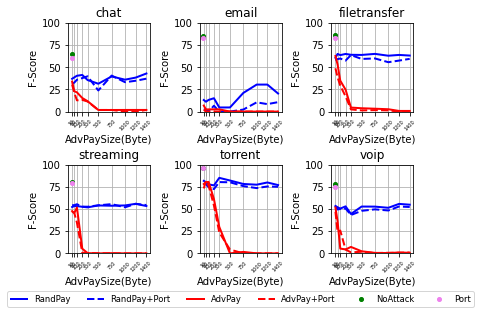

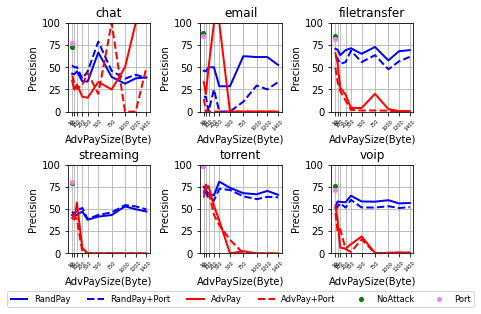

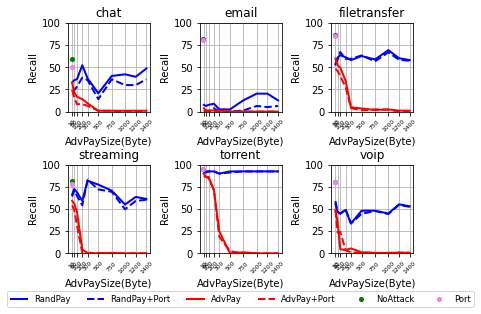

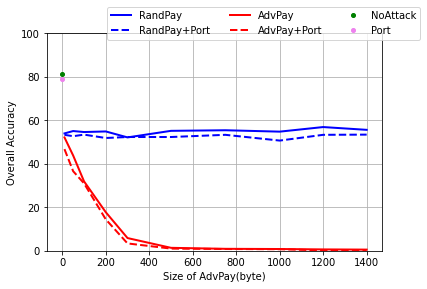

In [0]:

result_index = 0
f_score_name = "F-Score"
precision_name = "Precision"
recal_name = "Recall"
advpaysize_name = "AdvPaySize"
class_name = ['chat','email','filetransfer','streaming','torrent','voip']
for attack in AttackList:
    for i in range(len(class_name)):
        attack[f_score_name + class_name[i]] = result_stat[result_index, 0][ i]
        attack[precision_name + class_name[i]] = result_stat[result_index, 1][ i]
        attack[recal_name + class_name[i]] = result_stat[result_index, 2][ i]
    attack['Accuracy'] = result_stat[result_index,3]
    attack[advpaysize_name + class_name[i]] = result_stat[result_index, 4]
    result_index += 1

RawAttackList = AttackList

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import math

result_index = 0




def get_attack(attack_list,attack):
    for ref_attack,i in zip(attack_list,range(len(attack_list))):
        if ref_attack['PortAttack'] == attack['PortAttack'] and ref_attack['RandAttack'] == attack['RandAttack'] and ref_attack['AdvPayAttack'] == attack['AdvPayAttack'] and ref_attack['AdvPaySize'] == attack['AdvPaySize']:
            return i
    return None


AttackList = []
for new_attack in RawAttackList:
    old_attack_index = get_attack(AttackList,new_attack)
    if old_attack_index == None:
        new_attack['num_of_exper'] = 1
        AttackList.append(new_attack)
    else:
        for clsname in class_name:
            AttackList[old_attack_index][f_score_name+clsname] += new_attack[f_score_name+clsname]
            AttackList[old_attack_index][precision_name+clsname] += new_attack[precision_name+clsname]
            AttackList[old_attack_index][recal_name+clsname] += new_attack[recal_name+clsname]
        AttackList[old_attack_index]['num_of_exper'] += 1
for attack in AttackList:
    for clsname in class_name:
        attack[f_score_name+clsname] = attack[f_score_name+clsname] / attack['num_of_exper']
        attack[precision_name+clsname] = attack[precision_name+clsname] / attack['num_of_exper']
        attack[recal_name+clsname] = attack[recal_name+clsname] / attack['num_of_exper']


flag_recall = 0
class Attack_Result:
    def __init__(self,atc_res_list,metric_name,cls_name):
        self.attack_res = {}
        natural = []
        port = []
        rand = []
        advPay = []
        rand_port = []
        advPay_port = []
        AdvPaySize = []
        for attack in atc_res_list:
            assert (attack["AdvPayAttack"] != attack["RandAttack"]), "Attack information is wrong"
            if math.isnan(attack[metric_name + cls_name]) :
                attack[metric_name + cls_name] = 0
            if attack["AdvPayAttack"] == 1 and attack["Steps"] == 0:
                if attack["PortAttack"] == 0:
                    natural.append(attack[metric_name+cls_name])
                else:
                    port.append(attack[metric_name+cls_name])
            if attack["AdvPayAttack"] == 1 and attack["Steps"] > 0:
                if attack["PortAttack"] == 0:
                    advPay.append(attack[metric_name+cls_name])

                else:
                    advPay_port.append(attack[metric_name+cls_name])
            if attack["RandAttack"] == 1:
                if attack["PortAttack"] == 0:
                    rand.append(attack[metric_name+cls_name])
                    AdvPaySize.append(attack["AdvPaySize"])
                else:
                    rand_port.append(attack[metric_name+cls_name])
                    #AdvPaySize.append(attack["AdvPaySize"])
        self.attack_res["natural"] = np.array(natural)
        self.attack_res["port"] = np.array(port)
        self.attack_res["rand"] = np.array(rand)
        self.attack_res["rand_port"] = np.array(rand_port)
        self.attack_res["advPay"] = np.array(advPay)
        self.attack_res["advPay_port"] = np.array(advPay_port)
        self.attack_res["AdvPaySize"] = np.array(AdvPaySize)


class metrics:
        def __init__(self,atc_res_list,cls_name=None):
            if cls_name:
                self.f_score = Attack_Result(atc_res_list,f_score_name,cls_name)
                self.precision = Attack_Result(atc_res_list,precision_name,cls_name)
                self.recall = Attack_Result(atc_res_list,recal_name,cls_name)
            else:
                self.accuracy = Attack_Result(atc_res_list,'Accuracy',cls_name='')

class chart_data:
    def __init__(self,Attck_result_list):
        self.classes = {}
        self.classes["chat"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[0])
        self.classes["email"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[1])
        self.classes["filetransfer"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[2])
        self.classes["streaming"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[3])
        self.classes["torrent"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[4])
        self.classes["voip"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[5])

acc_data = metrics(AttackList)

cdata = chart_data(Attck_result_list=AttackList)



#df = pd.DataFrame({'x': data.classes["chat"].f_score.attack_res["overhead"], 'y1': data.classes["chat"].f_score.attack_res["rand"], 'y3': data.classes["chat"].f_score.attack_res["rand_port"])




if flag_recall == 0:
    fig, axes = plt.subplots(2, 3)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

    class_index = 0
    for ax in axes.flatten():
        ax.set_title(class_name[class_index])
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["rand"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].f_score.attack_res["rand"],
                   color='blue', linewidth=2, label="RandPay")
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["rand_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].f_score.attack_res["rand_port"],
                  color='blue', linewidth=2,linestyle='dashed', label="RandPay+Port")
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["advPay"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].f_score.attack_res["advPay"],
                  color='red', linewidth=2, label="AdvPay")
        if len(cdata.classes[class_name[class_index]].f_score.attack_res["advPay_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].f_score.attack_res["AdvPaySize"],cdata.classes[class_name[class_index]].f_score.attack_res["advPay_port"],
                color='red', linewidth=2, linestyle='dashed', label="AdvPay+Port")
        if cdata.classes[class_name[class_index]].f_score.attack_res["natural"]:
            ax.plot([0], cdata.classes[class_name[class_index]].f_score.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
        if cdata.classes[class_name[class_index]].f_score.attack_res["port"]:
            ax.plot([0], cdata.classes[class_name[class_index]].f_score.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
        ax.set( ylim=(0, 100))
        ax.grid()
        ax.set_xticks(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"])
        ax.tick_params(axis='x', rotation=45, labelsize=5)
        if class_index == 4:
            handles, labels = ax.get_legend_handles_labels()

        class_index += 1

    for ax in axes.flat:
        ax.set(xlabel='AdvPaySize(Byte)', ylabel='F-Score')
    fig.legend( handles, labels ,loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    fig.show()


if flag_recall == 0:
    fig, axes = plt.subplots(2,3)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

    class_index = 0
    for ax in axes.flatten():
        ax.set_title(class_name[class_index])
        if len(cdata.classes[class_name[class_index]].precision.attack_res["rand"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].precision.attack_res["rand"],
                   color='blue', linewidth=2, label="RandPay")
        if len(cdata.classes[class_name[class_index]].precision.attack_res["rand_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].precision.attack_res["rand_port"],
                  color='blue', linewidth=2,linestyle='dashed', label="RandPay+Port")
        if len(cdata.classes[class_name[class_index]].precision.attack_res["advPay"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].precision.attack_res["advPay"],
                  color='red', linewidth=2, label="AdvPay")
        if len(cdata.classes[class_name[class_index]].precision.attack_res["advPay_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"],cdata.classes[class_name[class_index]].precision.attack_res["advPay_port"],
                color='red', linewidth=2, linestyle='dashed', label="AdvPay+Port")
        if cdata.classes[class_name[class_index]].precision.attack_res["natural"]:
            ax.plot([0], cdata.classes[class_name[class_index]].precision.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
        if cdata.classes[class_name[class_index]].precision.attack_res["port"]:
            ax.plot([0], cdata.classes[class_name[class_index]].precision.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
        ax.set( ylim=(0, 100))
        ax.grid()
        ax.set_xticks(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"])
        ax.tick_params(axis='x', rotation=45, labelsize=5)
        if class_index == 4:
            handles, labels = ax.get_legend_handles_labels()

        class_index += 1
    for ax in axes.flat:
        ax.set(xlabel='AdvPaySize(Byte)', ylabel='Precision')
    fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    fig.show()


if True:
    fig, axes = plt.subplots(2,3)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.6)

    class_index = 0
    for ax in axes.flatten():
        ax.set_title(class_name[class_index])
        if len(cdata.classes[class_name[class_index]].recall.attack_res["rand"])is not 0 :
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].recall.attack_res["rand"],
                   color='blue', linewidth=2, label="RandPay")
        if len(cdata.classes[class_name[class_index]].recall.attack_res["rand_port"]) is not 0 :
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].recall.attack_res["rand_port"],
                  color='blue', linewidth=2,linestyle='dashed', label="RandPay+Port")
        if len(cdata.classes[class_name[class_index]].recall.attack_res["advPay"]) is not 0 :
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvPaySize"], cdata.classes[class_name[class_index]].recall.attack_res["advPay"],
                  color='red', linewidth=2, label="AdvPay")
        if len(cdata.classes[class_name[class_index]].recall.attack_res["advPay_port"]) is not 0:
            ax.plot(cdata.classes[class_name[class_index]].recall.attack_res["AdvPaySize"],cdata.classes[class_name[class_index]].recall.attack_res["advPay_port"],
                color='red', linewidth=2, linestyle='dashed', label="AdvPay+Port")
        if cdata.classes[class_name[class_index]].recall.attack_res["natural"]:
            ax.plot([0], cdata.classes[class_name[class_index]].recall.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
        if cdata.classes[class_name[class_index]].recall.attack_res["port"]:
            ax.plot([0], cdata.classes[class_name[class_index]].recall.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
        ax.set( ylim=(0, 100))
        ax.grid()
        ax.set_xticks(cdata.classes[class_name[class_index]].precision.attack_res["AdvPaySize"])
        ax.tick_params(axis='x', rotation=45, labelsize=6)
        if class_index == 4:
            handles, labels = ax.get_legend_handles_labels()

        class_index += 1



    for ax in axes.flat:
        ax.set(xlabel='AdvPaySize(Byte)', ylabel='Recall')
    fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
    fig.show()



if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if len(acc_data.accuracy.attack_res['rand']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['AdvPaySize'],acc_data.accuracy.attack_res['rand'],color='blue', linewidth=2, label="ًRandPay")
    if len(acc_data.accuracy.attack_res['rand_port']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['AdvPaySize'],acc_data.accuracy.attack_res['rand_port'],color='blue', linewidth=2,linestyle='dashed', label="RandPay+Port")
    if len(acc_data.accuracy.attack_res['advPay']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['AdvPaySize'],acc_data.accuracy.attack_res['advPay'],color='red', linewidth=2, label="AdvPay")
    if len(acc_data.accuracy.attack_res['advPay_port']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['AdvPaySize'],acc_data.accuracy.attack_res['advPay_port'],color='red', linewidth=2, linestyle='dashed', label="AdvPay+Port")
    if len(acc_data.accuracy.attack_res['natural']) is not 0:
        ax.plot([0.0],acc_data.accuracy.attack_res['natural'], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
    if len(acc_data.accuracy.attack_res['port']) is not 0:
        ax.plot([0.0],acc_data.accuracy.attack_res['port'],marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
    ax.set(xlabel='Size of AdvPay(byte)', ylabel='Overall Accuracy')
    ax.set( ylim=(0, 100))
    ax.grid()
    fig.legend( handles, labels, bbox_to_anchor = (0,-0.01,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=3,fontsize='medium' )
    fig.show()








